In [1]:
import re
import itertools
import numpy as np
import pandas as pd
from scipy.stats import skew, normaltest, probplot

import impyute as impy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

In [2]:
housing = pd.read_csv("Data/Melbourne_housing_EDA.csv")
housing.head().T

,0,1,2,3,4
Suburb,Abbotsford,Abbotsford,Abbotsford,Abbotsford,Abbotsford
Address,68 Studley St,85 Turner St,25 Bloomburg St,18/659 Victoria St,5 Charles St
Rooms,2,2,2,3,3
Type,h,h,h,u,h
Price,-9999.0,1480000.0,1035000.0,-9999.0,1465000.0
Method,SS,S,S,VB,SP
SellerG,Jellis,Biggin,Biggin,Rounds,Biggin
Date,3/09/2016,3/12/2016,4/02/2016,4/02/2016,4/03/2017
Distance,2.5,2.5,2.5,2.5,2.5
Postcode,3067.0,3067.0,3067.0,3067.0,3067.0


## Incomplete features

### 1.	Detection of missing values

**1.	Missing values encoded as NaN, NaT, or None.**

In [3]:
nan = {col:housing[col].isnull().sum() for col in housing.columns}
nan

{'Suburb': 0,
 'Address': 0,
 'Rooms': 0,
 'Type': 0,
 'Price': 0,
 'Method': 0,
 'SellerG': 0,
 'Date': 0,
 'Distance': 1,
 'Postcode': 0,
 'Bedroom2': 0,
 'Bathroom': 0,
 'Car': 8728,
 'Landsize': 11810,
 'BuildingArea': 21115,
 'YearBuilt': 19306,
 'CouncilArea': 1397,
 'Lattitude': 7976,
 'Longtitude': 7976,
 'Regionname': 3,
 'Propertycount': 3}

**2.	Missing values encoded in some non-standard way that is described in the data dictionary.** 

In [6]:
{col : np.sum(housing[col].isin(["notavailable", "missing"])) 
     if np.dtype(housing[col])==object 
     else "is numeric" for col in housing.columns}

{'Suburb': 0,
 'Address': 0,
 'Rooms': 'is numeric',
 'Type': 0,
 'Price': 'is numeric',
 'Method': 0,
 'SellerG': 0,
 'Date': 0,
 'Distance': 'is numeric',
 'Postcode': 280,
 'Bedroom2': 0,
 'Bathroom': 8226,
 'Car': 'is numeric',
 'Landsize': 'is numeric',
 'BuildingArea': 'is numeric',
 'YearBuilt': 'is numeric',
 'CouncilArea': 0,
 'Lattitude': 'is numeric',
 'Longtitude': 'is numeric',
 'Regionname': 0,
 'Propertycount': 'is numeric'}

In [7]:
num_nan_dict = {col : np.sum(housing[col].isin([-9999,0])) 
                if np.dtype(housing[col])!=object 
                else "is text" for col in housing.columns}
num_nan_dict

{'Suburb': 'is text',
 'Address': 'is text',
 'Rooms': 0,
 'Type': 'is text',
 'Price': 7610,
 'Method': 'is text',
 'SellerG': 'is text',
 'Date': 'is text',
 'Distance': 77,
 'Postcode': 'is text',
 'Bedroom2': 'is text',
 'Bathroom': 'is text',
 'Car': 1631,
 'Landsize': 2437,
 'BuildingArea': 76,
 'YearBuilt': 0,
 'CouncilArea': 'is text',
 'Lattitude': 0,
 'Longtitude': 0,
 'Regionname': 'is text',
 'Propertycount': 0}

**3.	Missing values of a numeric feature encoded as a string that is not described in the data dictionary**

In [8]:
pd.DataFrame(data={col:{'type':np.dtype(housing[col]).name, 'sample':housing.loc[100,col]} 
           for col in housing.columns}).T

,type,sample
Suburb,object,Airport West
Address,object,180 Parer Rd
Rooms,int64,3
Type,object,h
Price,float64,830000.0
Method,object,S
SellerG,object,Barry
Date,object,16/04/2016
Distance,float64,13.5
Postcode,object,3042.0


In [9]:
for col in ['Bathroom','Bedroom2', 'Postcode']:
    missing = np.unique([i for i in housing[col] 
                              if re.match(r'^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$', i) is None])
    print(col, ' : ', missing)

Bathroom  :  ['notavailable']
Bedroom2  :  ['-']
Postcode  :  ['missing']


**4.	Missing values of a numeric feature encoded as an extreme numeric value.**

In [10]:
pd.DataFrame(data={col : {'max_value': np.max(housing[col]), 
                           'min_value': np.min(housing[col])}  
                    for col in housing.columns 
                    if np.dtype(housing[col])!=object}).T

,max_value,min_value
Rooms,1.600000e+01,1.00000
Price,1.120000e+07,-9999.00000
Distance,4.810000e+01,0.00000
Car,2.600000e+01,0.00000
Landsize,4.330140e+05,0.00000
BuildingArea,4.451500e+04,0.00000
YearBuilt,2.106000e+03,1196.00000
Lattitude,-3.739020e+01,-38.19043
Longtitude,1.455264e+02,144.42379
Propertycount,2.165000e+04,83.00000


**5.	Missing values in non-numeric  column encoded as a string that is not described in the data dictionary.**

In [11]:
expected = {'Type' : ['br','h','u','t','dev site','o res']}
{col: np.unique([housing.loc[i,col] for i in housing[col].index 
                                             if not housing.loc[i,col] in expected[col]]) 
                             for col in housing.columns if col in expected.keys()}


{'Type': array(['UNK'], dtype='<U3')}

### 2.	Missing values encoding

In [12]:
housing_nan = housing.applymap(lambda x: np.nan if x in ['notavailable','missing','-','UNK',-9999] else x)
housing_nan['BuildingArea'] = housing_nan['BuildingArea'].replace(0, np.nan)
housing_nan[housing_nan['YearBuilt'] > 2016] = np.nan 
housing_nan.fillna(value = np.nan, inplace = True)

In [13]:
housing_nan = housing_nan.astype({'Suburb': object, 
                                 'Address':object, 
                                 'Rooms':np.number, 
                                 'Type':object, 
                                 'Price':np.number, 
                                 'Method':object,
                                 'SellerG': object,
                                 'Distance': np.number,
                                 'Postcode':  np.number, 
                                 'Bedroom2': np.number, 
                                 'Bathroom': np.number, 
                                 'Car': np.number,
                                 'Landsize': np.number, 
                                 'BuildingArea': np.number, 
                                 'CouncilArea': object, 
                                 'Lattitude': np.number,
                                 'Longtitude': np.number, 
                                 'Regionname': object, 
                                 'YearBuilt' : object ,
                                 'Propertycount': np.number})
housing_nan['Date'] = pd.to_datetime(housing_nan['Date'], format="%d/%M/%Y")

In [14]:
housing_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         34769 non-null  object        
 1   Address        34769 non-null  object        
 2   Rooms          34769 non-null  float64       
 3   Type           32338 non-null  object        
 4   Price          27176 non-null  float64       
 5   Method         34769 non-null  object        
 6   SellerG        34769 non-null  object        
 7   Date           34769 non-null  datetime64[ns]
 8   Distance       34768 non-null  float64       
 9   Postcode       34490 non-null  float64       
 10  Bedroom2       26552 non-null  float64       
 11  Bathroom       26543 non-null  float64       
 12  Car            26043 non-null  float64       
 13  Landsize       22980 non-null  float64       
 14  BuildingArea   13583 non-null  float64       
 15  YearBuilt      1546

### 3.	Deciding on a strategy
**2.	Evaluating the extend of the problem.**

In [15]:
pct = pd.DataFrame(data ={'col_name' :housing_nan.columns,  
                          'pct_detected_nan' :  [round((housing_nan[col].isnull().sum())*100/housing_nan.shape[0],3) 
                                                 for col in housing_nan.columns]})
pct.sort_values(by='pct_detected_nan',inplace=True)
pct = pd.concat([pct, 
                 pd.DataFrame(data={'col_name': ['All'],
                                         'pct_detected_nan': round(np.average(pct['pct_detected_nan'].values),3)}
                             )
                ]
               )
pct

,col_name,pct_detected_nan
0,Suburb,0.252
1,Address,0.252
2,Rooms,0.252
5,Method,0.252
6,SellerG,0.252
7,Date,0.252
8,Distance,0.255
19,Regionname,0.261
20,Propertycount,0.261
9,Postcode,1.053


**3.	Understanding the patterns of missingness.**

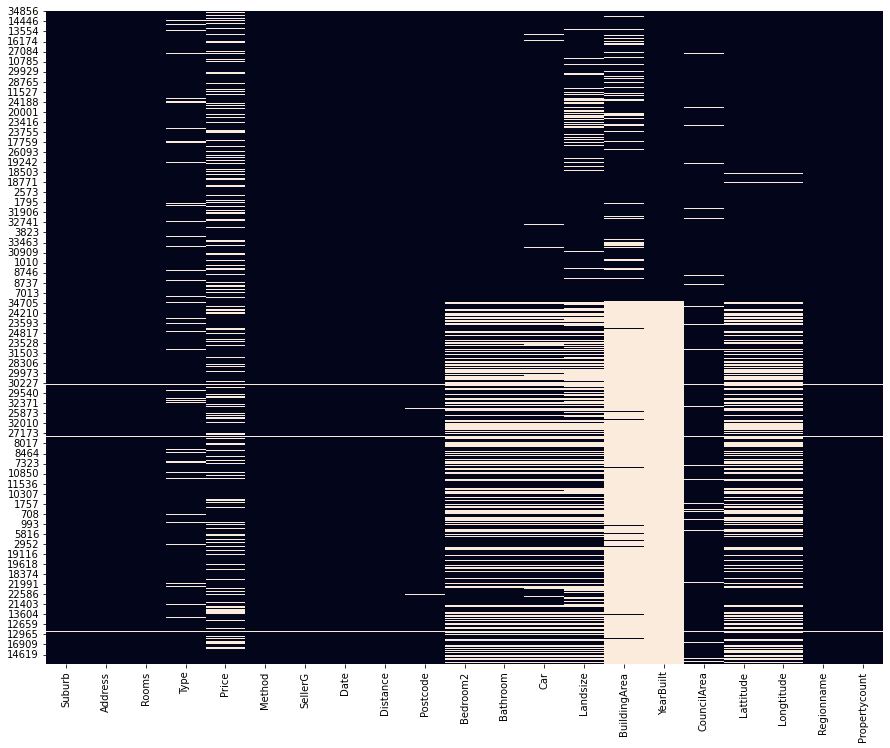

In [16]:
matplotlib.rcParams['figure.figsize'] = [15,12]
sns.heatmap(housing_nan.isnull().sort_values(by="YearBuilt"), cbar=False);

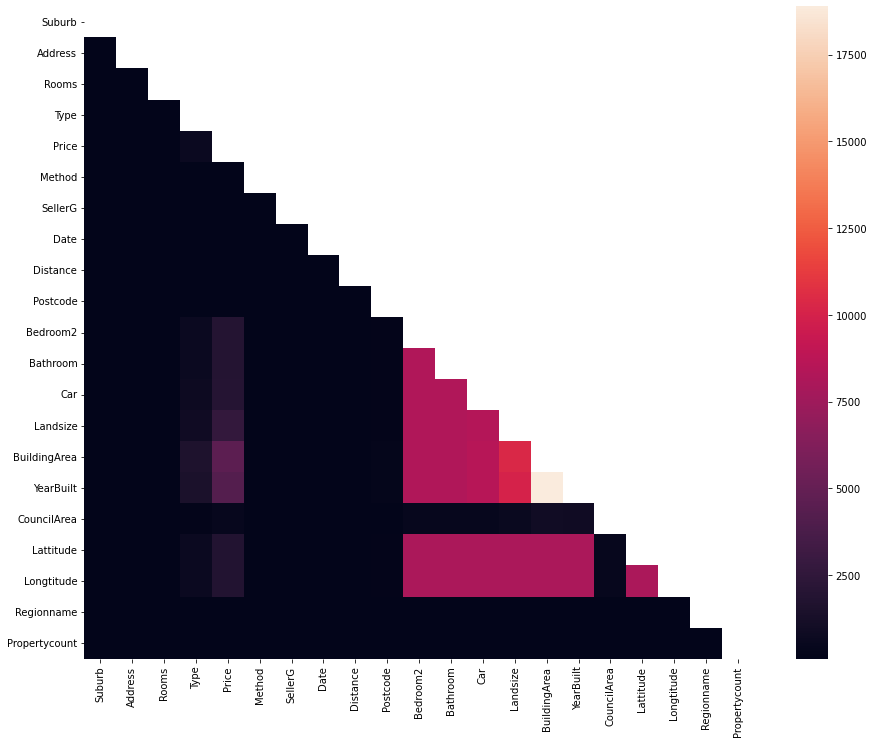

In [45]:
matplotlib.rcParams['figure.figsize'] = [15,12]
df = pd.DataFrame(columns=housing_nan.columns, index =housing_nan.columns)
for col1 in housing_nan.columns:
    for col2 in housing_nan.columns:
        df.loc[col1,col2] = housing_nan[(housing_nan[col1].isnull()) & (housing_nan[col2].isnull())].shape[0]
df = df.loc[:, (df != 0).any(axis=0)] 
df = df.loc[(df != 0).any(axis=1),:] 
df = df.astype(np.number)
mask = np.triu(df)
sns.heatmap(df, mask=mask);

### 4.	Handling missing values

**2.	Drop missing values.**

In [46]:
housing_nan.shape

(34857, 21)

In [47]:
housing_nan['indicator'] = [1 if (housing_nan.loc[i,['YearBuilt','BuildingArea']].isnull().sum()!=0) 
                            else 0 
                            for i in range(housing_nan.shape[0])]

In [48]:
housing_nan['weight'] = [1-(housing_nan.iloc[i,:].isnull().sum()/housing_nan.shape[1])
                         for i in range(housing_nan.shape[0])]

In [49]:
housing_nan.dropna(axis=0, how='any', subset=["Price"], inplace=True)
housing_nan.dropna(axis=1, how='any', thresh = 0.5*housing_nan.shape[0], inplace=True)
housing_nan.dropna(axis=0, how='any', thresh = 0.5*housing_nan.shape[1], inplace=True)

In [50]:
housing_nan.shape

(27175, 21)

**3.	Imputation with a single value.**

In [55]:
housing_nan['Car'].fillna(housing_nan['Car'].median(), inplace=True)
housing_nan['Type'].fillna(housing_nan['Type'].mode()[0], inplace=True)
housing_nan['Postcode'].fillna(0, inplace=True)

**4. Forward and backward filling**

In [56]:
housing_nan.sort_values(by=["Postcode"], ascending=True, inplace=True)
housing_nan["CouncilArea"] = housing_nan["CouncilArea"].ffill()

**5.	Model-based imputation.**

In [57]:
df = housing_nan[['Rooms', 'Price', 'Distance', 'Car', 'Propertycount','Lattitude','Longtitude']].copy()
df.reset_index(drop=True, inplace=True)
df_em = pd.DataFrame(data = impy.em(df.values, loops=100), columns = df.columns)                     
housing_nan[['Lattitude','Longtitude']] = df_em[['Lattitude','Longtitude']].values

In [58]:
df = housing_nan[['Rooms', 'Price', 'Distance', 'Car', 'Propertycount', 'Landsize']].copy()
df.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
df_mm = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
imputer = KNNImputer(n_neighbors=5)
df_temp = pd.DataFrame(imputer.fit_transform(df_mm), columns = df_mm.columns)
df_knn = pd.DataFrame(scaler.inverse_transform(df_temp), columns = df_temp.columns)
housing_nan[['Landsize']] = df_knn[['Landsize']].values

In [60]:
housing_nan.shape

(27175, 21)

**6.	Multiple imputation.**

In [61]:
df = housing_nan[['Rooms','Distance', 'Car', 'Propertycount', 'Landsize', 'Lattitude','Longtitude', 'Bathroom', 'Bedroom2']].copy()
iterations = 5
d = {'df'+str(i): pd.DataFrame() for i in range(iterations)}
for i in range(iterations):
    imputer = IterativeImputer(random_state=10**i, sample_posterior=True)
    imputer.fit(df)
    imp = imputer.transform(df)
    d['df'+str(i)] = pd.DataFrame(imp, columns=df.columns)
    d['df'+str(i)].loc[d['df'+str(i)]['Bathroom']< 0, 'Bathroom'] = 0
    d['df'+str(i)].loc[d['df'+str(i)]['Bedroom2']< 0, 'Bedroom2'] = 0

In [62]:
housing_nan['Bathroom'] = np.mean([d['df'+str(i)][['Bathroom']].values for i in range(iterations)], axis=0)
housing_nan['Bedroom2'] = np.mean([d['df'+str(i)][['Bedroom2']].values for i in range(iterations)], axis=0)

In [63]:
housing_nan.to_csv("Data/Melbourne_housing_imp.csv", index=False)

## Numerical features

In [113]:
housing_imp = pd.read_csv("Data/Melbourne_housing_imp.csv")
housing_num = housing_imp[[col for col in housing_nan.columns if np.dtype(housing_imp[col])==float]]

### 1.	Description of the data distribution

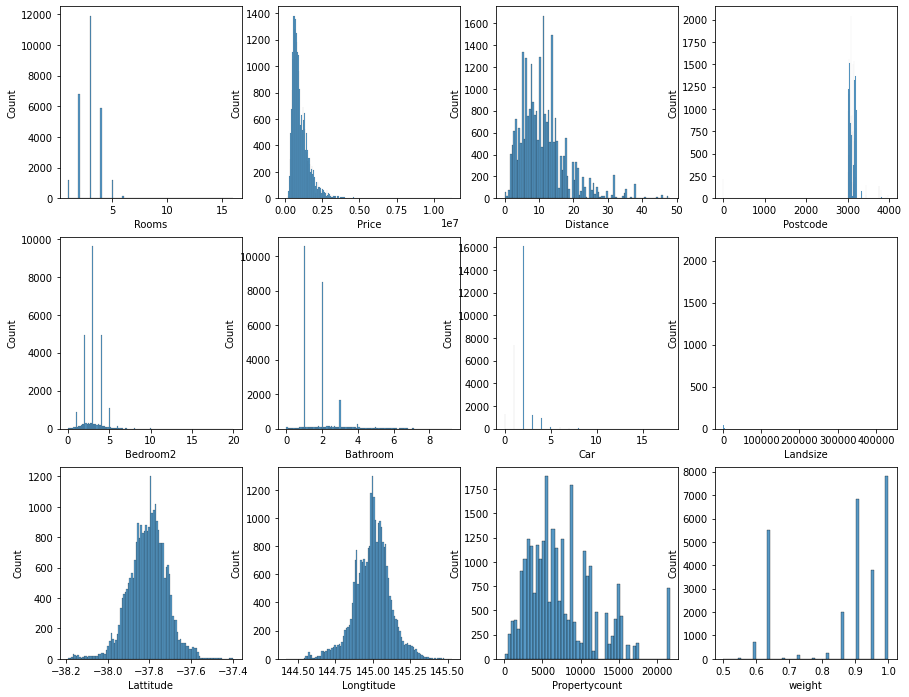

In [99]:
grid_rows = 3
grid_cols = housing_num.shape[1]/grid_rows

fig = plt.figure()
i=1
for col in housing_num.columns:
    ax = fig.add_subplot(grid_rows, int(np.ceil(grid_cols)), i)
    sns.histplot(housing_num[col])
    i+=1
plt.show();

In [100]:
df_num = pd.DataFrame(data= {col : {'skew': skew(housing_num[col]),
                                'mode':housing_num[col].mode()[0], 
                                'median':housing_num[col].median()} 
                    for col in housing_num.columns 
                    if np.dtype(housing_num[col])==float}).T
num_stats = pd.concat([df_num, housing_num.describe().T.iloc[:,1:]], axis=1)
num_stats

,skew,mode,median,mean,std,min,25%,50%,75%,max
Rooms,0.513387,3.0000,3.000000,2.991500e+00,0.954955,1.00000,2.000000,3.000000,4.000000e+00,1.600000e+01
Price,2.590408,600000.0000,870000.000000,1.050016e+06,641588.433817,85000.00000,635000.000000,870000.000000,1.295000e+06,1.120000e+07
Distance,1.476944,11.2000,10.400000,1.127633e+01,6.787120,0.00000,6.400000,10.400000,1.400000e+01,4.810000e+01
Postcode,-8.657484,3073.0000,3087.000000,3.089219e+03,296.584774,0.00000,3046.000000,3087.000000,3.152000e+03,3.978000e+03
Bedroom2,0.641101,3.0000,3.000000,3.019410e+00,1.032944,0.00000,2.000000,3.000000,4.000000e+00,2.000000e+01
Bathroom,1.594975,1.0000,2.000000,1.844074e+00,1.038359,0.00000,1.000000,2.000000,2.000000e+00,9.257247e+00
Car,1.599926,2.0000,2.000000,1.786495e+00,0.870026,0.00000,1.000000,2.000000,2.000000e+00,1.800000e+01
Landsize,104.175799,0.0000,505.000000,5.894953e+02,3126.518942,0.00000,250.000000,505.000000,6.540000e+02,4.330140e+05
Lattitude,-0.249553,-37.8361,-37.802100,-3.780723e+01,0.091200,-38.19043,-37.862779,-37.802100,-3.774860e+01,-3.739780e+01
Longtitude,-0.273068,144.9966,145.002077,1.449969e+02,0.120691,144.42379,144.924090,145.002077,1.450704e+02,1.455264e+02


### 2.	Normality testing

**1.	 Q-Q plot visualization**

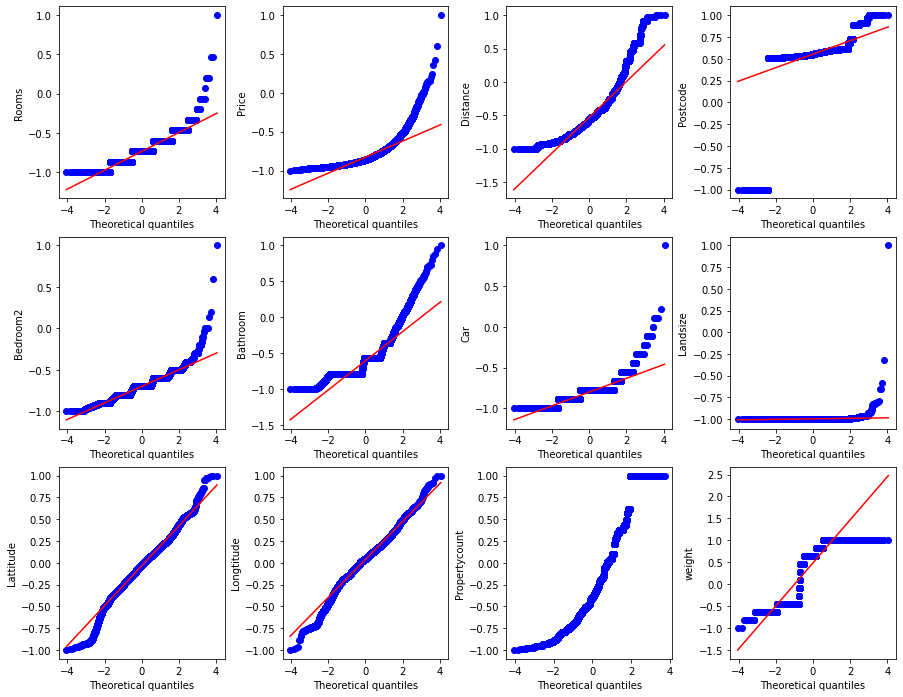

In [101]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_mm = pd.DataFrame(scaler.fit_transform(housing_num), columns = housing_num.columns)

grid_rows = 3
grid_cols = df_mm.shape[1]/grid_rows

fig = plt.figure()
i=1
for col in df_mm.columns:
    ax = fig.add_subplot(grid_rows, int(np.ceil(grid_cols)), i)
    probplot(df_mm[col].values, dist="norm", plot=plt)
    plt.title(None)
    plt.ylabel(col)
    i+=1
    
plt.subplots_adjust(wspace=0.35)    
plt.show();

**2.	Statistical testing for normality**

In [102]:
d = {'name':[],'statistic':[],'pvalue':[]}
for col in df_mm.columns:
    d['name'].append(col)
    stat, p = normaltest(df_mm[col])
    d['statistic'].append(stat)
    d['pvalue'].append(p)
pd.DataFrame(data=d)

,name,statistic,pvalue
0,Rooms,2866.351654,0.000000e+00
1,Price,16044.314605,0.000000e+00
2,Distance,7743.257061,0.000000e+00
3,Postcode,38619.155118,0.000000e+00
4,Bedroom2,4537.614171,0.000000e+00
5,Bathroom,8413.811869,0.000000e+00
6,Car,11311.193125,0.000000e+00
7,Landsize,109388.523750,0.000000e+00
8,Lattitude,871.934279,4.590680e-190
9,Longtitude,953.760179,7.827241e-208


### 3.	Skewed distributions and outliers


**2.	Square root transformation**

In [114]:
housing_imp["Distance"] = np.sqrt(housing_num["Distance"])

**3.	Log-transformation**

In [115]:
housing_imp["Price"] = np.log(housing_num["Price"])

## Categorical features

In [126]:
housing_cat = housing_imp[[col for col in housing_imp.columns if (np.dtype(housing_imp[col])==object) and col!='Date']]

### 1.	Data overview 

In [128]:
cardinality = pd.DataFrame(data={col : {'cardinality': len(housing_cat[col].unique()),
                                        'equal share': round(housing_cat.shape[0]/len(housing_cat[col].unique()),2)} 
                                 for col in housing_cat.columns}) 

cardinality

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
cardinality,344.0,26682.00,3.00,5.0,349.00,33.00,9.00
equal share,79.0,1.02,9058.33,5435.0,77.87,823.48,3019.44


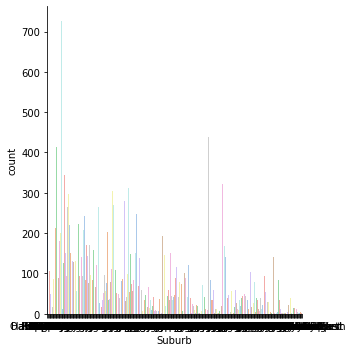

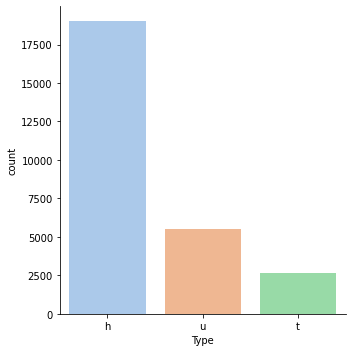

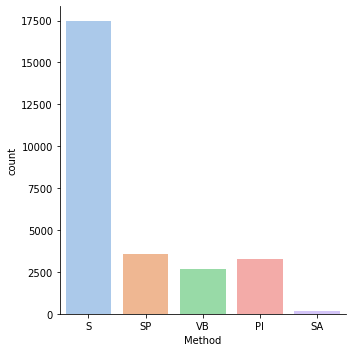

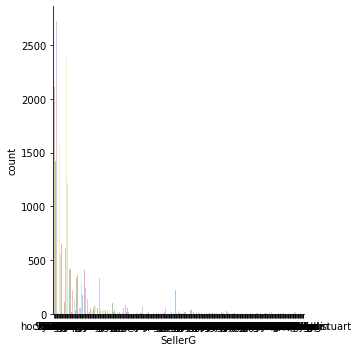

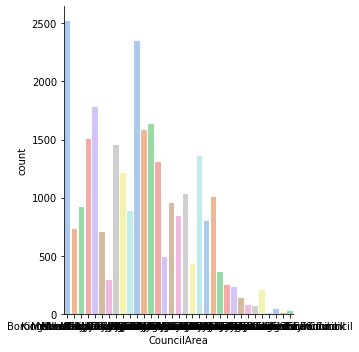

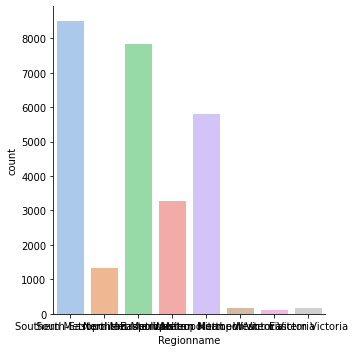

In [131]:
temp = housing_cat.drop(axis=1, columns=['Address'])

for col in temp.columns:
    sns.catplot(x=col , kind="count", palette="pastel", data=temp)
    plt.show();


### 2.	High Cardinality features

In [ ]:
col = 'CouncilArea'
cat_dist = df3.groupby(col).size().sort_values(ascending=False)
to_group = cat_dist.where(cat_dist<=500).dropna().index
housing_nan[col] = [val if val not in to_group else 'other' for val in housing_nan[col]]

### 3.	Data encoding

In [156]:
dummy = pd.get_dummies(df3['Type'])
housing_nan = pd.concat([housing_nan.drop(columns=['Type']), dummy])